### Own Built Model


In [3]:
# =============================
# 1. Imports & Device Setup
# =============================
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Check device (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# =============================
# 2. Data Preprocessing & Loaders
# =============================

# Define transforms (augment for train, simple resize for val/test)
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Point to dataset (download Chest X-Ray dataset from Kaggle first!)
train_dir = "/Users/zane/Desktop/Self Project/chest_xray/train"
val_dir   = "/Users/zane/Desktop/Self Project/chest_xray/val"
test_dir  = "/Users/zane/Desktop/Self Project/chest_xray/test"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


# =============================
# 3. Define CNN Model
# =============================

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [3,150,150] -> [32,150,150]
            nn.ReLU(),
            nn.MaxPool2d(2,2),                           # [32,75,75]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [64,75,75]
            nn.ReLU(),
            nn.MaxPool2d(2,2),                           # [64,37,37]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [128,37,37]
            nn.ReLU(),
            nn.MaxPool2d(2,2)                            # [128,18,18]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*18*18, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = PneumoniaCNN().to(device)


# =============================
# 4. Loss & Optimizer
# =============================
criterion = nn.BCELoss()  # Binary Cross-Entropy for 2-class problem
optimizer = optim.Adam(model.parameters(), lr=0.001)


# =============================
# 5. Training Loop
# =============================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs > 0.5).int()
                correct += (predicted == labels.int()).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history["train_loss"].append(running_loss/len(train_loader))
        history["val_loss"].append(val_loss/len(val_loader))
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} "
              f"| Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.4f}")
    
    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


# =============================
# 6. Test Evaluation
# =============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        correct += (predicted == labels.int()).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")


Using device: cpu
Train samples: 5216, Val: 16, Test: 624


Epoch 1/10: 100%|██████████| 163/163 [01:33<00:00,  1.73it/s]


Epoch 1/10 | Train Loss: 0.2459 | Val Loss: 1.0953 | Val Acc: 0.5000


Epoch 2/10: 100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Epoch 2/10 | Train Loss: 0.1504 | Val Loss: 0.4045 | Val Acc: 0.7500


Epoch 3/10: 100%|██████████| 163/163 [01:33<00:00,  1.73it/s]


Epoch 3/10 | Train Loss: 0.1255 | Val Loss: 0.7245 | Val Acc: 0.6875


Epoch 4/10: 100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


Epoch 4/10 | Train Loss: 0.1023 | Val Loss: 1.0901 | Val Acc: 0.5625


Epoch 5/10: 100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


Epoch 5/10 | Train Loss: 0.1013 | Val Loss: 0.4237 | Val Acc: 0.7500


Epoch 6/10: 100%|██████████| 163/163 [01:37<00:00,  1.67it/s]


Epoch 6/10 | Train Loss: 0.0914 | Val Loss: 0.6756 | Val Acc: 0.6875


Epoch 7/10: 100%|██████████| 163/163 [01:37<00:00,  1.68it/s]


Epoch 7/10 | Train Loss: 0.0854 | Val Loss: 0.6169 | Val Acc: 0.7500


Epoch 8/10: 100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch 8/10 | Train Loss: 0.0848 | Val Loss: 0.5619 | Val Acc: 0.7500


Epoch 9/10: 100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch 9/10 | Train Loss: 0.0697 | Val Loss: 0.3655 | Val Acc: 0.7500


Epoch 10/10: 100%|██████████| 163/163 [01:36<00:00,  1.69it/s]


Epoch 10/10 | Train Loss: 0.0748 | Val Loss: 0.8315 | Val Acc: 0.6875
Test Accuracy: 0.7660


### Import Trained Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===============================
# 1. Data Transforms (Augmentation)
# ===============================
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ===============================
# 2. Load dataset from folders
# ===============================
data_dir = "/Users/zane/Desktop/Self Project/chest_xray/test"  # full dataset folder with 'NORMAL' and 'PNEUMONIA'
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# ===============================
# 3. Split into random train/val/test
# ===============================
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply val/test transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ===============================
# 4. Load Pretrained ResNet18
# ===============================
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

# ===============================
# 5. Loss & Optimizer
# ===============================
criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # only fine-tune final layer

# ===============================
# 6. Training Loop
# ===============================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).int()
                correct += (predicted == labels.int()).sum().item()
                total += labels.size(0)
        val_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} "
              f"| Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# ===============================
# 7. Test Evaluation
# ===============================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        predicted = (outputs > 0.5).int()
        correct += (predicted == labels.int()).sum().item()
        total += labels.size(0)
print(f"Test Accuracy on new random subset: {correct/total:.4f}")


Using device: cpu
Train: 499, Val: 62, Test: 63
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/zane/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 39.6MB/s]


Epoch 1/5 | Train Loss: 0.5856 | Val Loss: 0.5654 | Val Acc: 0.8065
Epoch 2/5 | Train Loss: 0.4459 | Val Loss: 0.5296 | Val Acc: 0.6452
Epoch 3/5 | Train Loss: 0.3598 | Val Loss: 0.4464 | Val Acc: 0.7581
Epoch 4/5 | Train Loss: 0.3387 | Val Loss: 0.3770 | Val Acc: 0.8226
Epoch 5/5 | Train Loss: 0.2847 | Val Loss: 0.4002 | Val Acc: 0.8226
Test Accuracy on new random subset: 0.8730


### HeatMap Of Test Using my Model


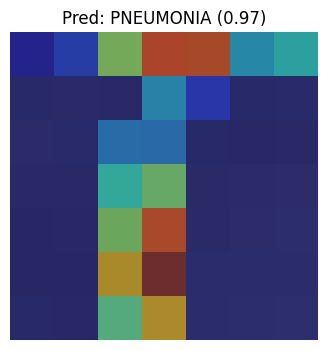

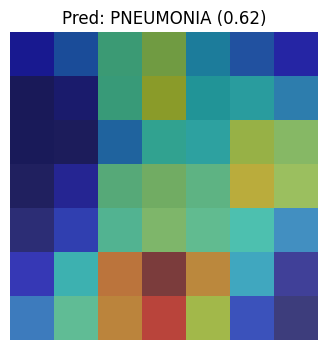

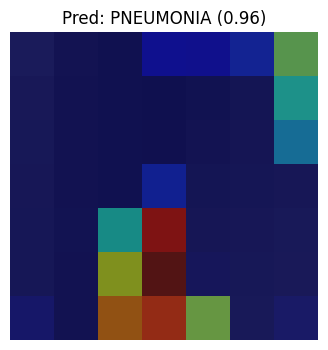

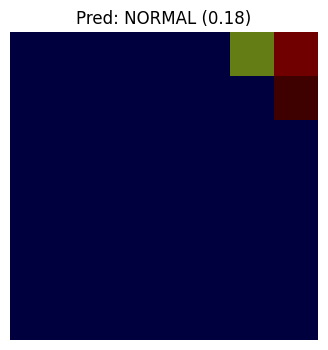

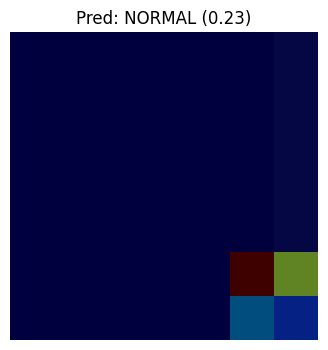

In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------
# 1. Pick test images (first 5 for demo)
# ------------------------------
num_images = 5
test_samples = [test_dataset[i] for i in range(num_images)]
images = torch.stack([x[0] for x in test_samples]).to(device)
labels = [x[1] for x in test_samples]

# ------------------------------
# 2. Unfreeze last conv layer for Grad-CAM
# ------------------------------
for param in model.layer4[1].parameters():
    param.requires_grad = True

features, gradients = None, None

def forward_hook(module, input, output):
    global features
    features = output  # no retain_grad() here

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

last_conv_layer = model.layer4[1].conv2
f_hook = last_conv_layer.register_forward_hook(forward_hook)
b_hook = last_conv_layer.register_backward_hook(backward_hook)


# ------------------------------
# 3. Forward pass and backward pass per image
# ------------------------------
for i in range(num_images):
    input_tensor = images[i].unsqueeze(0)
    model.eval()
    output = model(input_tensor)
    pred_prob = output.item()
    pred_class = 1 if pred_prob > 0.5 else 0

    # Backward pass
    model.zero_grad()
    target = torch.tensor([[pred_class]], dtype=torch.float).to(device)
    loss = F.binary_cross_entropy(output, target)
    loss.backward()

    # Grad-CAM computation
    weights = torch.mean(gradients, dim=(2,3), keepdim=True)
    grad_cam = torch.sum(weights * features, dim=1).squeeze()
    grad_cam = F.relu(grad_cam)
    grad_cam = grad_cam / grad_cam.max()
    grad_cam = grad_cam.cpu().detach().numpy()

    # Prepare original image for overlay
    img_np = images[i].cpu().permute(1,2,0).numpy()
    img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_np = np.clip(img_np, 0, 1)

    # Show overlay
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.title(f"Pred: {'PNEUMONIA' if pred_class==1 else 'NORMAL'} ({pred_prob:.2f})")
    plt.axis('off')
    plt.show()

# ------------------------------
# 4. Remove hooks
# ------------------------------
f_hook.remove()
b_hook.remove()


### Random Image + Original Photo + HeatMap and Prediction My Model


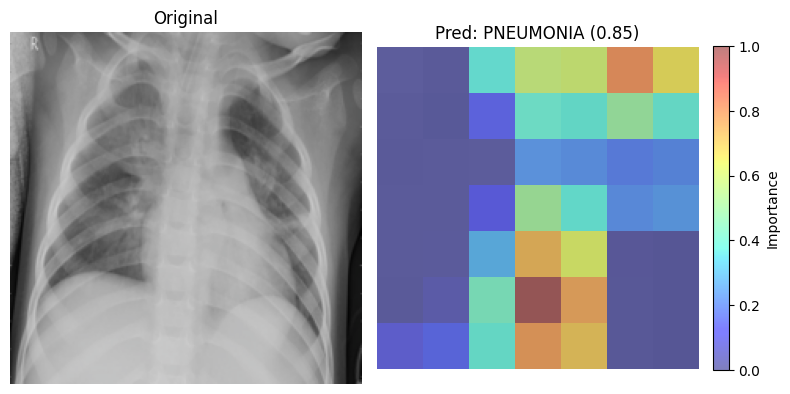

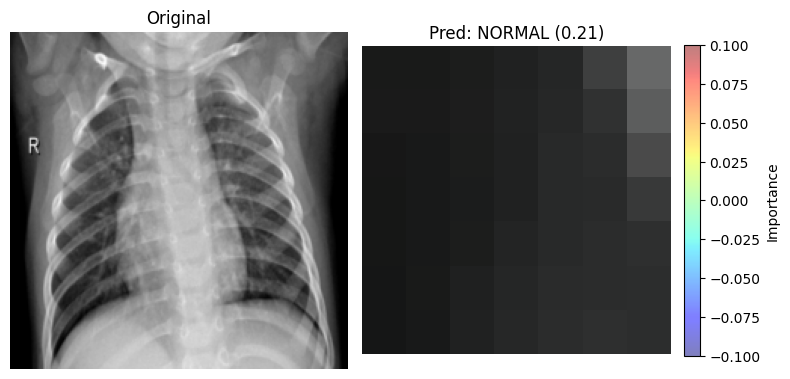

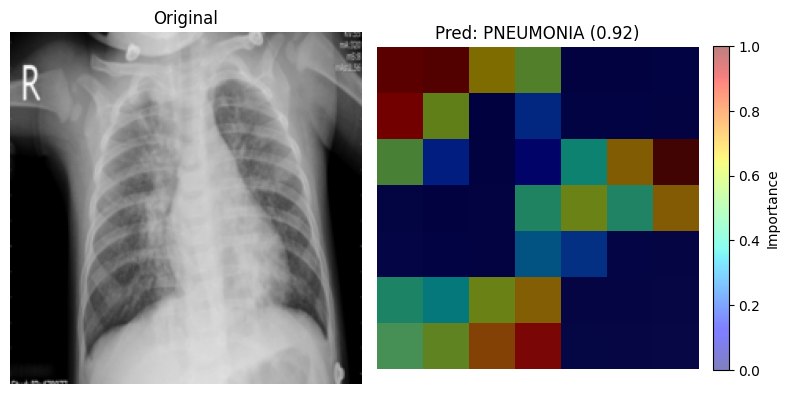

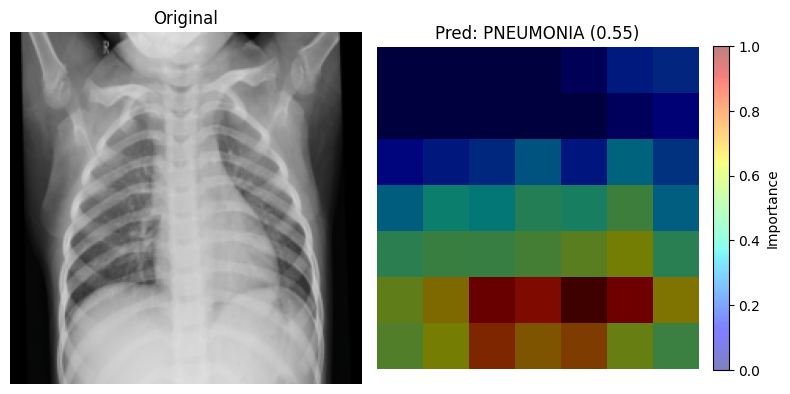

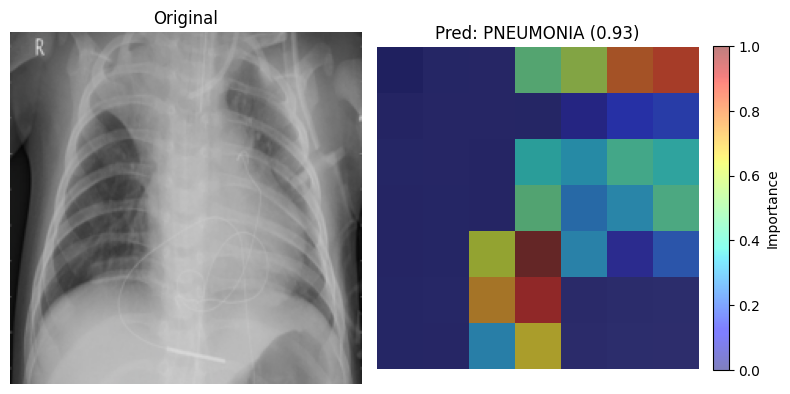

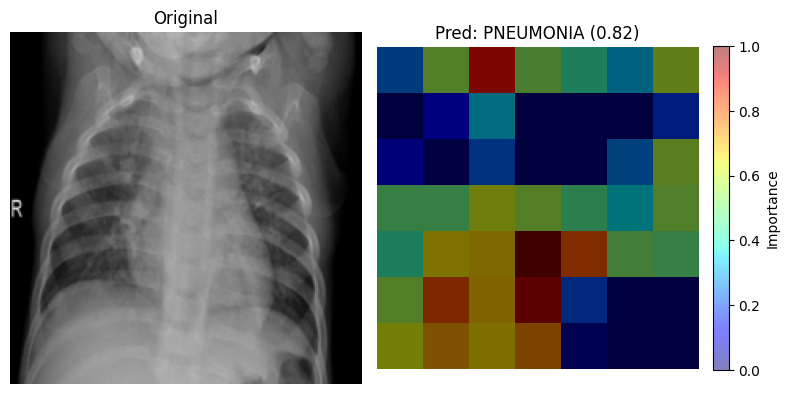

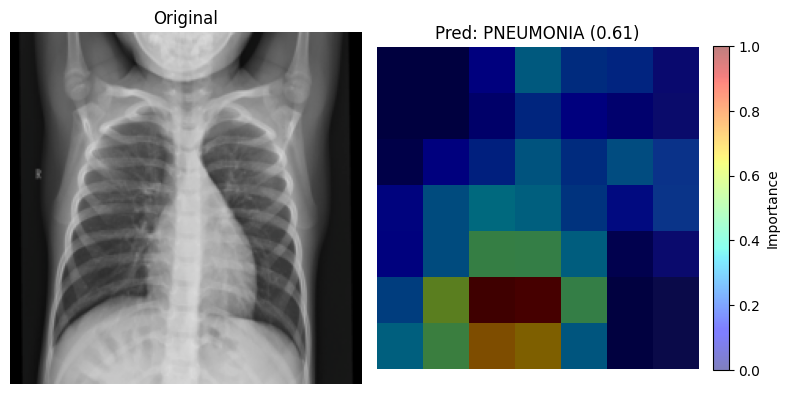

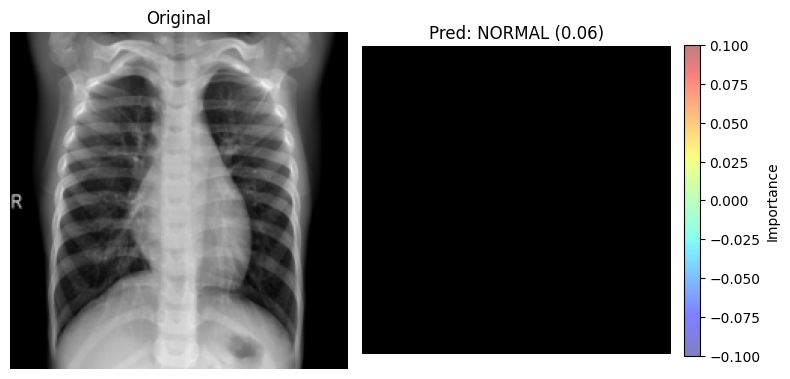

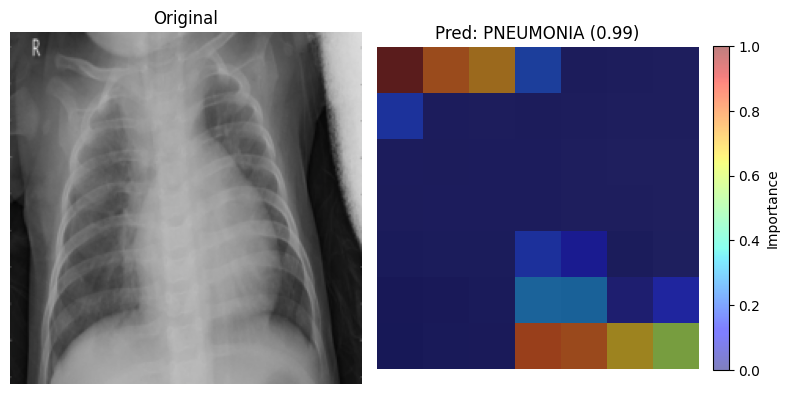

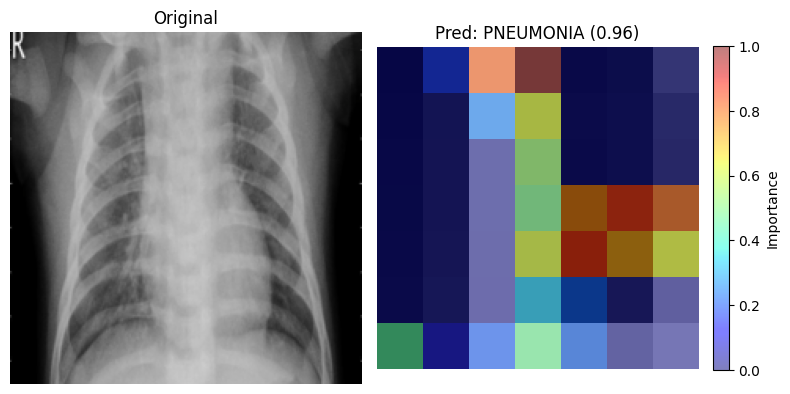

In [20]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# ------------------------------
# Parameters
# ------------------------------
num_images = 10  # number of random test images to visualize
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------
# Pick random test images
# ------------------------------
indices = random.sample(range(len(test_dataset)), num_images)
test_samples = [test_dataset[i] for i in indices]
images = torch.stack([x[0] for x in test_samples]).to(device)
labels = [x[1] for x in test_samples]

# ------------------------------
# Unfreeze last conv layer for Grad-CAM
# ------------------------------
for param in model.layer4[1].parameters():
    param.requires_grad = True

features, gradients = None, None

def forward_hook(module, input, output):
    global features
    features = output
    features.retain_grad()

def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

last_conv_layer = model.layer4[1].conv2
f_hook = last_conv_layer.register_forward_hook(forward_hook)
b_hook = last_conv_layer.register_backward_hook(backward_hook)

# ------------------------------
# Grad-CAM visualization
# ------------------------------
model.eval()
for i in range(num_images):
    input_tensor = images[i].unsqueeze(0)
    
    # Forward pass
    output = model(input_tensor)
    pred_prob = output.item()
    pred_class = 1 if pred_prob > 0.5 else 0

    # Backward pass
    model.zero_grad()
    target = torch.tensor([[pred_class]], dtype=torch.float).to(device)
    loss = F.binary_cross_entropy(output, target)
    loss.backward()

    # Compute Grad-CAM
    weights = torch.mean(gradients, dim=(2,3), keepdim=True)
    grad_cam = torch.sum(weights * features, dim=1).squeeze()
    grad_cam = F.relu(grad_cam)
    grad_cam = grad_cam / grad_cam.max()
    grad_cam = grad_cam.cpu().detach().numpy()

    # Prepare original image
    img_np = images[i].cpu().permute(1,2,0).numpy()
    img_np = img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_np = np.clip(img_np, 0, 1)

    # ------------------------------
    # Plot original + heatmap side by side
    # ------------------------------
    plt.figure(figsize=(8,4))

    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis('off')

    # Heatmap overlay
    plt.subplot(1,2,2)
    plt.imshow(img_np)
    heatmap = plt.imshow(grad_cam, cmap='jet', alpha=0.5)
    plt.title(f"Pred: {'PNEUMONIA' if pred_class==1 else 'NORMAL'} ({pred_prob:.2f})")
    plt.axis('off')
    plt.colorbar(heatmap, fraction=0.046, pad=0.04, label="Importance")
    
    plt.tight_layout()
    plt.show()

# ------------------------------
# Remove hooks
# ------------------------------
f_hook.remove()
b_hook.remove()
